# Part 1: Setup

In [ ]:
#@title Import Packages and Data - **Edit Code**

# ==========
# import necessary packages
# ==========

# standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime

# widget packages
import ipywidgets as widgets
from IPython.display import HTML, Markdown, display

# statistics and advanced plotting packages
from IPython.display import display
from IPython.display import clear_output
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import statsmodels.api as sm
from scipy import stats
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.stats import qmc
from scipy.stats import mstats
from scipy.stats import stats as stats
import scipy.optimize as opt
from scipy.stats import norm
import seaborn as sns


# ==========
# import astro imaging data and setup
# ==========

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# EDIT FILENAME

# change the filename inside the quotes to match the name of the file you uploaded
# you don't need to change anything else, and make sure to leave the quotes there!

df = pd.read_csv('Test_VG_Uranus_Data.csv') 

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


# ==========
# Data cleaning - replace text or missing values with NaN
# ==========

#for col in df.columns:
#    df[col] = pd.to_numeric(df[col], errors='coerce')
#df = df.astype(np.float64)
# Convert 'N' column to np.int64
#df['N'] = df['N'].astype(np.int64)


# **********
# Manual Error messages
# **********

col_names = list(df.columns)

name_flag_arr = [0,0,0,0,0,0,0,0,0,0]
type_flag_arr = [0,0,0,0,0,0,0,0,0,0]
name_arr = ["N","Decimal Day (UT)","Moon1 (RA)","Moon1 (Dec)","Moon2 (RA)","Moon2 (Dec)",
            "Moon1 (dRA)","Moon1 (dDec)","Moon2 (dRA)","Moon2 (dDec)"]
type_arr = [np.int64,np.float64,np.float64,np.float64,np.float64,np.float64,np.float64,
            np.float64,np.float64,np.float64]
ctr_x = [0,1,2,3,4,5,6,7,8,9]

# check each column off as we process the column name list
# must have the right name and datatype
for i in col_names:                           # for each column name
  for j in ctr_x:                             # check against the whole list
    if i == name_arr[j]:                  # if it's in the list
        name_flag_arr[j] = 1              # check it off
        if df[i].dtypes == type_arr[j]:    # if it also has the right type
          type_flag_arr[j] = 1            # check that off too

error_name = False
error_type = False

# Then check for any errors
for i in name_flag_arr:
  if i == 0:
    error_name = True
for i in type_flag_arr:
  if i == 0:
    error_type = True

# enter print statement
if error_name:
  print("\n\033[2;31;43mWARNING: The following column names were not found:\033[0;0m\n")
  for i in ctr_x:
    if name_flag_arr[i] == 0:
      print(" -%s" % name_arr[i])
if error_type:
  print("\n\033[2;31;43mWARNING: The following columns are missing or have incorrect datatypes:\033[0;0m")
  #print("(Columns which were not found are also reported as having incorrect datatypes)\n")
  for i in ctr_x:
    if type_flag_arr[i] == 0:
      print(" -%s" % name_arr[i])


                    

In [ ]:
#@title View Data Table

# =========
# DATA CLEANING
# =========

# Remove rows of pure NaN
df.dropna(how = 'all', inplace = True)

# Remove rows with Nan in a needed data column
df.dropna(subset=['Moon1 (dRA)'], inplace=True)
df.dropna(subset=['Moon1 (dDec)'], inplace=True)
df.dropna(subset=['Moon2 (dRA)'], inplace=True)
df.dropna(subset=['Moon2 (dDec)'], inplace=True)

df.reset_index()


# =======
# FUNCTIONS
# =======

# CREATE DROPDOWNS
# function for creating dropdowns using widget functionality in Colab
def create_dropdown(choices, first, des):
  return widgets.Dropdown(
      options = choices,
      value = choices[first],
      description = des+":", 
      disabled=False,
      )

# CART2POL
# convert cartesian coordinates to polar
def cart2pol(x,y):
  rho = np.sqrt(x**2 + y**2)
  theta = np.arctan2(y,x)
  return(rho,theta)

# create polar coordinates and add to data set
[M1_dr,M1_dth] = cart2pol(df['Moon1 (dRA)'],df['Moon1 (dDec)'])
[M2_dr,M2_dth] = cart2pol(df['Moon2 (dRA)'],df['Moon2 (dDec)'])

df['Moon1 (r)'] = M1_dr
df['Moon1 (theta)'] = M1_dth
df['Moon2 (r)'] = M2_dr
df['Moon2 (theta)'] = M2_dth




# ===========
# create a table view as well
# ===========

dfview = df[['N','Decimal Day (UT)', 'Moon1 (RA)', 'Moon1 (dRA)', 
             'Moon1 (Dec)', 'Moon1 (dDec)', 'Moon1 (r)', 'Moon1 (theta)',
       'Moon2 (RA)', 'Moon2 (dRA)', 'Moon2 (Dec)', 'Moon2 (dDec)', 
       'Moon2 (r)', 'Moon2 (theta)']].round(3)


display(dfview)


## Get to know your data

Use the data table above displays your data. Scan the table to check that they were imported correctly. 

The dRA column is $\Delta$RA and represents the difference between the moon RA and Uranus RA. The dDec column is $\Delta$Dec and represents the difference between moon dec and Uranus dec. The (r) and (theta) columns are calculated automatically from the dRA and dDec columns in the spreadsheet you uploaded. They are polar representations of the dRA and dDec coordinates together. 

**Questions:**

1.   Skim the rows of your data. Are the entries in ascending chronological order?
2. What are the units of each of the columns?


---

**Answers:**

*double click me to edit this text and respond to the questions!*





# Part 2: Descriptive Plotting

In [ ]:
#@title Plot moon observations in sky coordinates

# Extract the dX_pos and dY_pos columns for each moon
M1_x = df['Moon1 (RA)']
M1_y = df['Moon1 (Dec)']
M2_x = df['Moon2 (RA)']
M2_y = df['Moon2 (Dec)']
date = df['Decimal Day (UT)'].values.reshape(-1, 1)
date_vec = date.flatten()

# ==========
# define  plot axis limits
# ==========
min_M1x = np.min(M1_x)
min_M2x = np.min(M2_x)
min_x = min(min_M1x, min_M2x) * 0.999
min_M1y = np.min(M1_y)
min_M2y = np.min(M2_y)
min_y = min(min_M1y, min_M2y) * 0.999

max_M1x = np.max(M1_x)
max_M2x = np.max(M2_x)
max_x = max(max_M1x, max_M2x) * 1.001
max_M1y = np.max(M1_y)
max_M2y = np.max(M2_y)
max_y = max(max_M1y, max_M2y) * 1.001


# make the plot
fig, (moon1, moon2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

# Plot X_pos vs Y_pos for Moon 1
moon1.scatter(M1_x, M1_y, c = date_vec, cmap = 'plasma', edgecolor = 'black', marker = 'o', label = "Moon 1")
moon1.set_title('Moon 1', fontsize = 16)
moon1.set_ylabel('Declination (degrees)', fontsize = 14)
moon1.set_xlim([min_x, max_x])
moon1.set_ylim([min_y, max_y])

# Plot X_pos vs Y_pos for Moon 2
moon2.scatter(M2_x, M2_y, c = date_vec, cmap = 'plasma', edgecolor = 'black', marker = '^', label = "Moon 2")
moon2.set_title('Moon 2', fontsize = 16)
moon2.set_xlim([min_x, max_x])
moon2.set_ylim([min_y, max_y])

# add color bar
cbar = plt.colorbar(moon2.collections[0], ax = [moon1, moon2], format='%.0f')
cbar.ax.set_title('Day of Year')
cbar.ax.set_position([0.96, 0.1, 0.02, 0.8]) 

# Add a main x-axis label
fig.text(0.5, 0, 'RA (degrees)', ha = 'center', fontsize = 14)

# Add a main title
fig.suptitle('Observations in Sky Coordinates', fontsize = 20, y = 1.05)

# Adjust the spacing between subplots
fig.subplots_adjust(wspace = 0.3)

plt.show()



In [ ]:
#@title Plot moon observations in a polar projection - **Edit Code**

# Extract the dX_pos and dY_pos columns for each moon
M1_dx = df['Moon1 (dRA)']
M1_dy = df['Moon1 (dDec)']
M2_dx = df['Moon2 (dRA)']
M2_dy = df['Moon2 (dDec)']
date = df['Decimal Day (UT)'].values.reshape(-1, 1)
date_vec = date.flatten()
nindex = df['N']

display(Markdown("The radius axis is in units of arcseconds."))
display(Markdown("The angular axis is in units of degrees where 0º means due 'east' on the image"))

# Convert dY_pos vs dX_pos to theta and r
[M1_dr,M1_dth] = cart2pol(M1_dx,M1_dy)
[M2_dr,M2_dth] = cart2pol(M2_dx,M2_dy)

#widget for annotations

fig, ax = plt.subplots(subplot_kw={'projection':'polar'})
m1 = ax.scatter(M1_dth, 3600*M1_dr, c = date_vec, cmap = 'plasma', edgecolor = 'black', marker = 'o', label = "Moon 1")
cbar = plt.colorbar(m1, format='%.0f', pad = 0.2)
cbar.ax.set_title('Day of Year', pad = 0.05)

m2 = ax.scatter(M2_dth, 3600*M2_dr, c = date_vec, cmap = 'plasma', edgecolor = 'black', marker = '^', label = "Moon 2")

  
ax.set_rmax(np.ceil(1.2*3600*np.max(M1_dr)))
ax.set_rticks([np.ceil(0.4*3600*np.max(M1_dr)),np.ceil(0.8*3600*np.max(M1_dr)),np.ceil(1.2*3600*np.max(M1_dr))])

ax.set_title('Moon Orbits around Uranus', fontsize = 16)
ax.grid(True)
plt.legend(bbox_to_anchor=(1.2, 1.1))


# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# YOUR CODE HERE:
# Write an informative figure caption that will display beneath the plot
# Add "\n" to start a new line of text
plt.text(0.00, -0.019, 
         "Figure 1. [Type a figure caption here]",
         transform=plt.gcf().transFigure)



# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

plt.show()

## Response 1

**Questions:**

1.   Describe this plot: What are the axes? What does the origin (0, 0) represent?
2.   Based on this plot, estimate each moon's orbital semi-major axis. 
3.   What does this plot tell you about the eccentricity of the orbit and inclination of each moon's orbit? 


 

---

**Answers:**

*double click me to edit this text and respond to the questions!*

## Defining $R^2$ and Residuals

Next, we will create a model that describes or "fits" moon position over time. In this case, we will use a function for a line to describe trends in RA or dec over time. A "linear fit" uses statistical equations to draw a straight line that best describes the data (the straight line that comes the closest to all the points overall). We can also use other functions to model trends, like a quadratic or an exponential function.

When we fit a model to the data , we need to examine several measures of how well that model describes the data. First, **the $R^2$ value**, which is sometimes called the "goodness of fit". The $R^2$  measures how the proportion of variance in the dependent variable (Y) that is described by the independent variable (X). Values range from 0 to 1. If $R^2 = 0$, the dependent variable explains 0% of the variation in the independent variable.  If $R^2 = 1$, the model  explains 100% of the variation in the independent variable. 

Seond, when the model is not a perfect fit, indicated by an $R^2$ < 1 (almost always the case), we should visually assess **the residuals** of the model. A residual is simply the difference between the observed Y-value of a data point and the Y-value predicted by the model fit. If a data point plots above the model fit, the residual will be positive. If a data point plots below the model fit, the residual will be negative. When we plot residuals for every data point against the original X-axis, the shape of the residuals may reveal a better equation to use.

**Note:** *the code below may sometimes return a negative $R^2$ value if the fit is severely worse than a straight line. This is a small bug because $R^2$ values cannot be negative.*

The example below shows two data sets each fit with a linear equation:
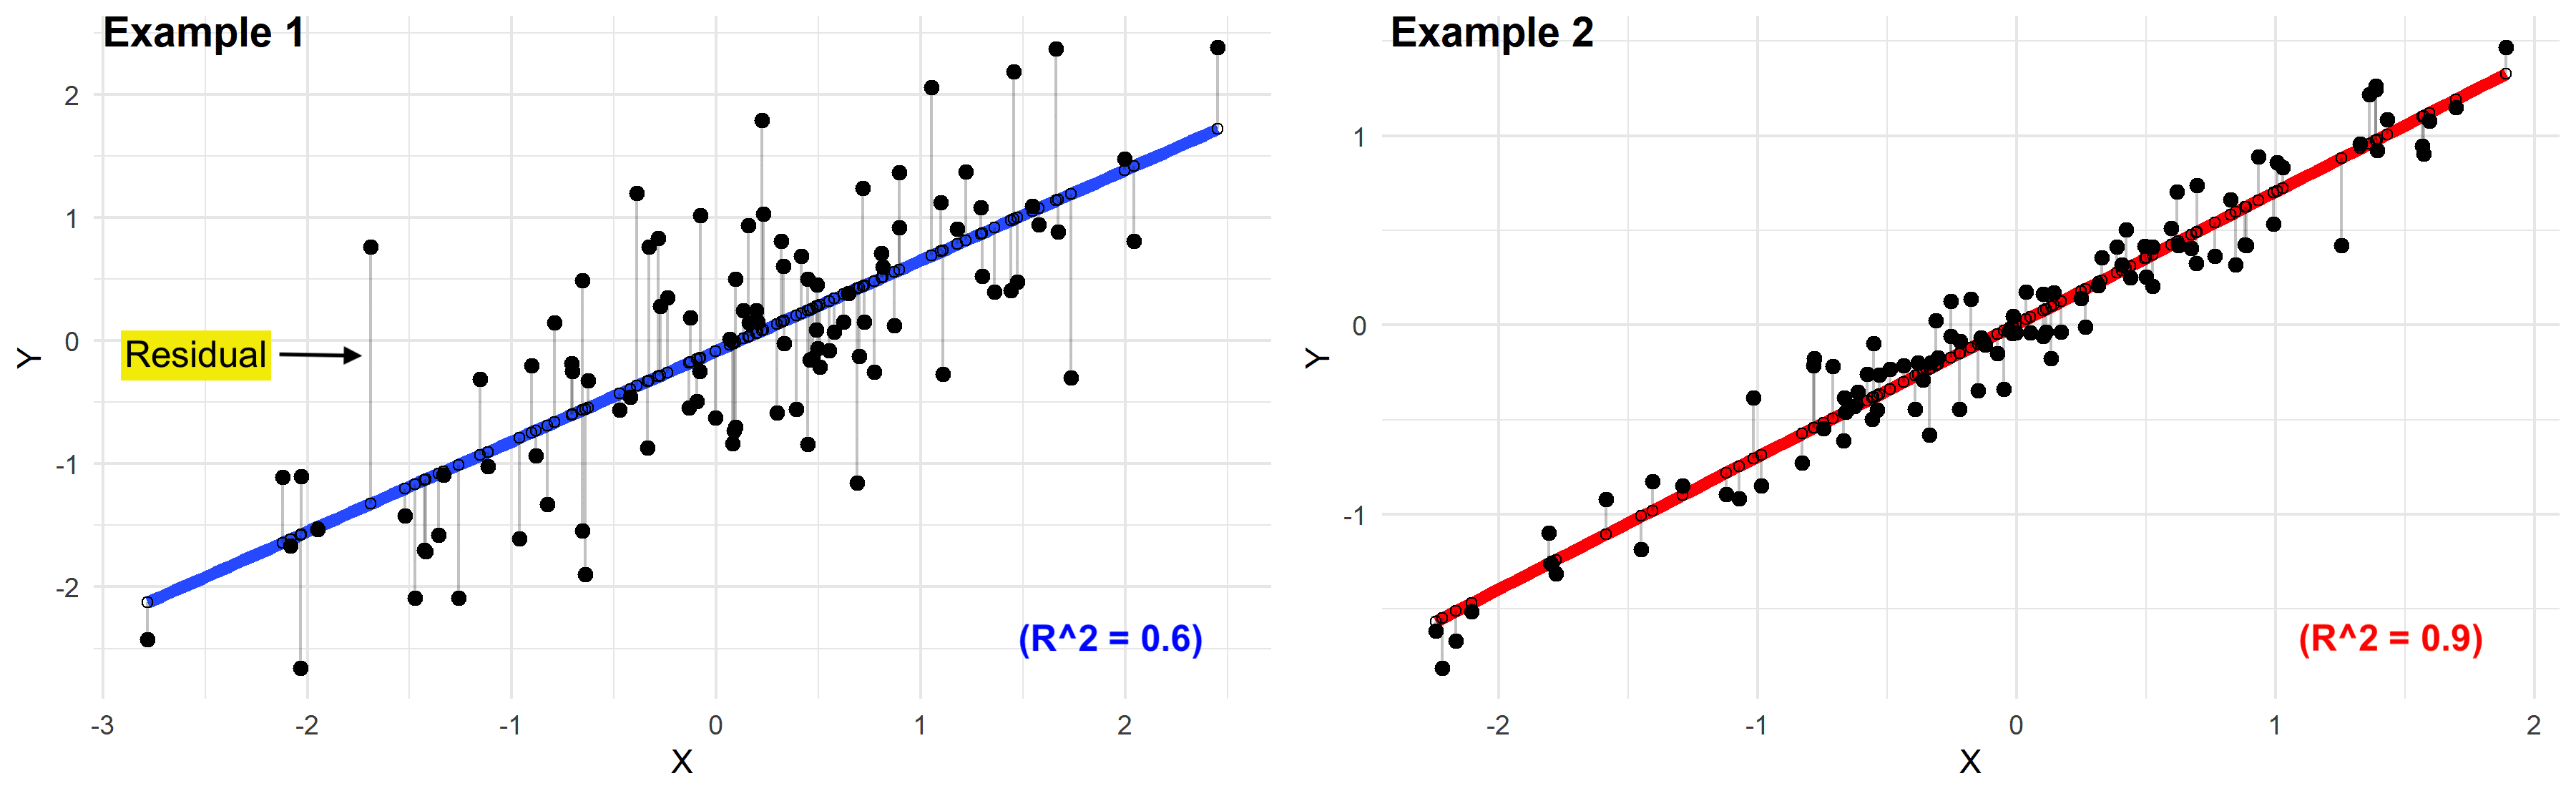

In [ ]:
#@title Examine moon position over time

# Extract the dX_pos, dY_pos and DateTime columns for each moon
M1_x = df['Moon1 (RA)'].values.reshape(-1, 1)
M1_y = df['Moon1 (Dec)'].values.reshape(-1, 1)
M2_x = df['Moon2 (RA)'].values.reshape(-1, 1)
M2_y = df['Moon2 (Dec)'].values.reshape(-1, 1)
date = df['Decimal Day (UT)'].values.reshape(-1, 1)
date_pred = np.arange(10, 41, 0.025)
widget3 = create_dropdown(["No Model", "Linear"],0,"Model")

# date - axis limits
min_date = np.min(date) * 0.95
max_date = np.max(date) * 1.05

# ==========
# LINEAR FITS 
# ==========
# moon 1
moon1x_lin = LinearRegression().fit(date, M1_x)
moon1x_lin_r2 = "R$^2$ = %.2f" % round(moon1x_lin.score(date, M1_x),2)
moon1x_resid_lin = M1_x - moon1x_lin.predict(date)

moon1y_lin = LinearRegression().fit(date, M1_y)
moon1y_lin_r2 = "R$^2$ = %.2f" % round(moon1y_lin.score(date, M1_y),2)
moon1y_resid_lin = M1_y - moon1y_lin.predict(date)

# moon 2
moon2x_lin = LinearRegression().fit(date, M2_x)
moon2x_lin_r2 = "R$^2$ = %.2f" % round(moon2x_lin.score(date, M2_x),2)
moon2x_resid_lin = M2_x - moon2x_lin.predict(date)

moon2y_lin = LinearRegression().fit(date, M2_y)
moon2y_lin_r2 = "R$^2$ = %.2f" % round(moon2y_lin.score(date, M2_y),2)
moon2y_resid_lin = M2_y - moon2y_lin.predict(date)


# ==========
# define residual plot axis limits
# ==========
min_m1xresid_lin = np.min(moon1x_resid_lin)
min_m1yresid_lin = np.min(moon1y_resid_lin)
min_m2xresid_lin = np.min(moon2x_resid_lin)
min_m2yresid_lin = np.min(moon2y_resid_lin)

min_resid = min(min_m1xresid_lin, min_m1yresid_lin, min_m2xresid_lin, min_m2yresid_lin,) * 1.4

max_m1xresid_lin = np.max(moon1x_resid_lin)
max_m1yresid_lin = np.max(moon1y_resid_lin)
max_m2xresid_lin = np.max(moon2x_resid_lin)
max_m2yresid_lin = np.max(moon2y_resid_lin)

max_resid = max(max_m1xresid_lin, max_m1yresid_lin, max_m2xresid_lin, max_m2yresid_lin,) * 1.4



# ==========
# ADD MODEL RESULTS TO FIG 2 
# ==========
def model_plot(drop3):
  # Create a figure with 2 x 2 subplots
  fig, ((moon1RA, moon2RA), (moon1Dec, moon2Dec), (moon1resid, moon2resid)) = plt.subplots(nrows=3, ncols=2, figsize=(11, 9), gridspec_kw={'height_ratios': [2, 2, 1]})


  # Plot dX_pos vs DateTime vs DateTime for Moon 1
  moon1RA.scatter(date, M1_x, color = 'red', label = 'RA')
  moon1RA.set_title('Moon 1', fontsize = 16)
  moon1RA.set_ylabel('Position (degrees)', fontsize = 14)
  moon1RA.set_xlim([min_date, max_date])

  # -----------
  # CHOOSING FIT TO APPLY: MOON 1 RA
  # -----------
  if drop3 == "No model":
    moon1RA.annotate(" ", xy = (0.5, 0.5), xycoords = 'axes fraction', color = 'gray', fontsize = 12, weight = 'bold')

  if drop3 == "Linear":
    moon1RA.plot(date, moon1x_lin.predict(date), color = 'red', linewidth = 2, label = 'RA Linear')
    moon1RA.annotate(moon1x_lin_r2, xy =(0.03, 0.92), xycoords='axes fraction', color = 'red', fontsize = 12, weight='bold')
    moon1Dec.plot(date, moon1y_lin.predict(date), color = 'blue', linewidth = 2, linestyle='--', label = 'Dec Linear')
    moon1Dec.annotate(moon1y_lin_r2, xy = (0.65, 0.03), xycoords = 'axes fraction', color = 'blue', fontsize = 12, weight = 'bold')
  else:
    # Don't fit
    moon1RA.annotate(" ", xy = (0.5, 0.5), xycoords = 'axes fraction', color = 'gray', fontsize = 12, weight = 'bold')



  # Plot X_pos vs DateTime vs DateTime for Moon 2
  moon2RA.scatter(date, M2_x, color = 'red', label = 'RA')
  moon2RA.set_title('Moon 2', fontsize = 16)
  moon2RA.set_xlim([min_date, max_date])

  # -----------
  # CHOOSING FIT TO APPLY: MOON 2 RA
  # -----------
    # -----------
  if drop3 == "No model":
      moon2RA.annotate(" ", xy = (0.5, 0.5), xycoords = 'axes fraction', color = 'gray', fontsize = 12, weight = 'bold')

  if drop3 == "Linear":
      moon2RA.plot(date, moon2x_lin.predict(date), color = 'red', linewidth = 2, label = 'RA Linear')
      moon2RA.annotate(moon2x_lin_r2, xy =(0.03, 0.92), xycoords='axes fraction', color = 'red', fontsize = 12, weight='bold')
  else:
    # Don't add a fit
    moon2RA.annotate("", xy = (0.5, 0.5), xycoords = 'axes fraction', color = 'gray', fontsize = 12, weight = 'bold')

  # moon 2 figure legend
  moon2RA.legend(loc = 'upper right', bbox_to_anchor = (1.45, 1), fontsize = 12)


  # Plot dY_pos vs DateTime vs DateTime for Moon 1
  moon1Dec.scatter(date, M1_y, color = 'blue', marker='s', label = 'Dec')
  moon1Dec.set_ylabel('Position (degrees)', fontsize = 14)
  moon1Dec.set_xlim([min_date, max_date])

  # -----------
  # CHOOSING FIT TO APPLY: MOON 1 Dec
  # -----------
  if drop3 == "No model":
    moon1Dec.annotate(" ", xy = (0.5, 0.5), xycoords = 'axes fraction', color = 'gray', fontsize = 12, weight = 'bold')

  if drop3 == "Linear":
    moon1Dec.plot(date, moon1y_lin.predict(date), color = 'blue', linewidth = 2, linestyle='--', label = 'Dec Linear')
    moon1Dec.annotate(moon1y_lin_r2, xy = (0.65, 0.03), xycoords = 'axes fraction', color = 'blue', fontsize = 12, weight = 'bold')
  else:
    # Don't fit
    moon1Dec.annotate(" ", xy = (0.5, 0.5), xycoords = 'axes fraction', color = 'gray', fontsize = 12, weight = 'bold')



  # Plot Y_pos vs DateTime vs DateTime for Moon 2
  moon2Dec.scatter(date, M2_y, color = 'blue', marker='s', label = 'Dec')
  moon2Dec.set_xlim([min_date, max_date])

  # -----------
  # CHOOSING FIT TO APPLY: MOON 2 Dec
  # -----------
    # -----------
  if drop3 == "No model":
      moon2Dec.annotate(" ", xy = (0.5, 0.5), xycoords = 'axes fraction', color = 'gray', fontsize = 12, weight = 'bold')

  if drop3 == "Linear":
      moon2Dec.plot(date, moon2y_lin.predict(date), color = 'blue', linewidth = 2, linestyle='--', label = 'Dec Linear')
      moon2Dec.annotate(moon2y_lin_r2, xy = (0.65, 0.03), xycoords = 'axes fraction', color = 'blue', fontsize = 12, weight = 'bold')
  else:
    # Don't add a fit
    moon2Dec.annotate("", xy = (0.5, 0.5), xycoords = 'axes fraction', color = 'gray', fontsize = 12, weight = 'bold')

  # moon 2 figure legend
  moon2Dec.legend(loc = 'upper right', bbox_to_anchor = (1.45, 1), fontsize = 12)




  # -----------
  # ADD RESIDUALS PLOTS
  # -----------
  if drop3 == "No model":
    # plot residuals for moon 1
    moon1resid.annotate("No model ", xy = (0.5, 0.5), xycoords = 'axes fraction', color = 'gray', fontsize = 12, weight = 'bold')


  if drop3 == "Linear":
    # plot residuals for moon 1
    moon1resid.stem(date, moon1x_resid_lin, linefmt='r-', markerfmt='ro', basefmt='k-')  
    moon1resid.stem(date, moon1y_resid_lin, linefmt='b-', markerfmt='bs', basefmt='k-')  
    moon1resid.set_ylabel('Residuals', fontsize = 14)
    moon1resid.set_ylim([min_resid, max_resid])
    moon1resid.set_xlim([min_date, max_date])

    # plot residuals for moon 2
    moon2resid.stem(date, moon2x_resid_lin, linefmt='r-', markerfmt='ro', basefmt='k-', label = 'RA')  
    moon2resid.stem(date, moon2y_resid_lin, linefmt='b-', markerfmt='bs', basefmt='k-', label = "Dec")  
    moon2resid.legend(loc = 'upper right', bbox_to_anchor = (1.3, 1), fontsize = 12)
    moon2resid.set_ylim([min_resid, max_resid])
    moon2resid.set_xlim([min_date, max_date])

  else:
    # Don't add residuals plot
    moon1resid.annotate("No model", xy = (0.5, 0.5), xycoords = 'axes fraction', color = 'gray', fontsize = 12, weight = 'bold')

  # Add a main x-axis label
  fig.text(0.5, 0.05, 'Day of Year', ha = 'center', fontsize = 14)

  # Add a main title
  fig.suptitle('Uranus Moons', fontsize = 20)

  # Adjust the spacing between subplots
  fig.subplots_adjust(wspace = 0.2)

  # display the plot
  plt.show()


# ============
# CALL INTERACTIVE WIDGET
# ===========

widgets.interact(model_plot, drop3 = widget3)



## RESPONSE 2

Use the drop down menu to apply a linear model to RA and dec vs. time for each moon. 

**Questions:**

1.   Discuss how well the linear fit describes the motion of the moons. 
2.   Examine the residuals plots and provide an explanation for any patterns that you see.
3. What type of function might fit this data better (quadratic, exponential, sinusoidal, etc.)?

---

**Answers:**

*double click me to edit this text and respond to the questions!*

In [ ]:
#@title Examine relative (delta) moon positions over time

# Extract the dX_pos, dY_pos and DateTime columns for each moon
M1_x = df['Moon1 (RA)']
M1_y = df['Moon1 (Dec)']
M2_x = df['Moon2 (RA)']
M2_y = df['Moon2 (Dec)']
M1_dx = df['Moon1 (dRA)']
M1_dy = df['Moon1 (dDec)']
M2_dx = df['Moon2 (dRA)']
M2_dy = df['Moon2 (dDec)']
date = df['Decimal Day (UT)']
nindex = df['N']

# Position Angle is obtained as just theta from a polar plot
[M1_dr,M1_dth] = cart2pol(M1_dx,M1_dy)
[M2_dr,M2_dth] = cart2pol(M2_dx,M2_dy)


# =========
# define axis limits based on min and max values
# =========
# date - axis limits
min_date = np.min(date) * 0.95
max_date = np.max(date) * 1.05

# x, y axis limits
min_M1x = np.min(M1_x)
min_M2x = np.min(M2_x)
min_M1y = np.min(M1_y)
min_M2y = np.min(M2_y)
min_pos = min(min_M1x, min_M2x, min_M1y, min_M2y) * 0.8

max_M1x = np.max(M1_x)
max_M2x = np.max(M2_x)
max_M1y = np.max(M1_y)
max_M2y = np.max(M2_y)
max_pos = max(max_M1x, max_M2x, max_M1y, max_M2y) * 1.2

# dx, dy axis limits
min_M1dx = np.min(M1_dx)
min_M2dx = np.min(M2_dx)
min_M1dy = np.min(M1_dy)
min_M2dy = np.min(M2_dy)
min_dpos = min(min_M1dx, min_M2dx, min_M1dy, min_M2dy) * 1.2

max_M1dx = np.max(M1_dx)
max_M2dx = np.max(M2_dx)
max_M1dy = np.max(M1_dy)
max_M2dy = np.max(M2_dy)
max_dpos = max(max_M1dx, max_M2dx, max_M1dy, max_M2dy) * 1.2

# d theta axis limits
min_M1dth = np.min(M1_dth)
min_M2dth = np.min(M2_dth)
min_dth = min(min_M1dth, min_M2dth) * 1.2

max_M1dth = np.max(M1_dth)
max_M2dth = np.max(M2_dth)
max_dth = max(max_M1dth, max_M2dth) * 1.2


# rotating position vector for annotations
rot_dpos = []
for i in nindex:
  if (i % 6) == 1:
    rot_dpos = np.append(rot_dpos,min_dpos)
  elif (i % 6) == 2:
    rot_dpos = np.append(rot_dpos,min_dpos*0.9)
  elif (i % 6) == 3:
    rot_dpos = np.append(rot_dpos,min_dpos*0.8)
  elif (i % 6) == 4:
    rot_dpos = np.append(rot_dpos,max_dpos)
  elif (i % 6) == 5:
    rot_dpos = np.append(rot_dpos,max_dpos*0.9)
  else:
    rot_dpos = np.append(rot_dpos,max_dpos*0.8)

rot_dth = []
for i in nindex:
  if (i % 6) == 1:
    rot_dth = np.append(rot_dth,min_dth)
  elif (i % 6) == 2:
    rot_dth = np.append(rot_dth,min_dth*0.9)
  elif (i % 6) == 3:
    rot_dth = np.append(rot_dth,min_dth*0.8)
  elif (i % 6) == 4:
    rot_dth = np.append(rot_dth,max_dth)
  elif (i % 6) == 5:
    rot_dth = np.append(rot_dth,max_dth*0.9)
  else:
    rot_dth = np.append(rot_dth,max_dth*0.8)

# create widgets
widget1 = create_dropdown(["RA","Dec","PA"], 0, "Moon 1")
widget2 = create_dropdown(["RA","Dec","PA"], 0, "Moon 2")

def choose_plot(drop1, drop2):
  # Create a figure with two subplots arranged horizontally
  fig, (moon1, moon2) = plt.subplots(ncols = 2, figsize = (11, 4))

  # Plot request vs Datetime for Moon 1
  if drop1 == "RA":
    moon1.scatter(date, M1_dx, color = 'red', label = 'RA')
    moon1.set_title('Moon 1', fontsize = 16)
    moon1.set_ylabel('Δ Position (degrees)', fontsize = 14)
    moon1.set_ylim([min_dpos, max_dpos])
    moon1.set_xlim([min_date, max_date])

  elif drop1 == "Dec":
    moon1.scatter(date, M1_dy, color = 'blue', marker='s', label = 'Dec')
    moon1.set_title('Moon 1', fontsize = 16)
    moon1.set_ylabel('Δ Position (degrees)', fontsize = 14)
    moon1.set_ylim([min_dpos, max_dpos])
    moon1.set_xlim([min_date, max_date])

  elif drop1 == "PA":
    moon1.scatter(date, M1_dth, color = 'green', marker = 'd', label = 'PA')
    moon1.set_title('Moon 1', fontsize = 16)
    moon1.set_ylabel('Δ Position (degrees)', fontsize = 14)
    moon1.set_ylim([min_dth, max_dth])
    moon1.set_xlim([min_date, max_date])

  moon1.legend(loc = 'lower right', fontsize = 12)

  # Plot request vs DateTime for Moon 2
  if drop2 == "RA":
    moon2.scatter(date, M2_dx, color = 'red', label = 'RA')
    moon2.set_title('Moon 2', fontsize = 16)
    moon2.set_ylim([min_dpos, max_dpos])
    moon2.set_xlim([min_date, max_date])

  elif drop2 == "Dec":
    moon2.scatter(date, M2_dy, color = 'blue', marker='s', label = 'Dec')
    moon2.set_title('Moon 2', fontsize = 16)
    moon2.set_ylim([min_dpos, max_dpos])
    moon2.set_xlim([min_date, max_date])

  elif drop2 == "PA":
    moon2.scatter(date, M2_dth, color = 'green', marker = 'd', label = 'PA')
    moon2.set_title('Moon 2', fontsize = 16)
    moon2.set_ylim([min_dth, max_dth])
    moon2.set_xlim([min_date, max_date])

  moon2.legend(loc = 'lower right', fontsize = 12)

  # Add a main x-axis label
  fig.text(0.5, -0.035, 'Day of Year', ha = 'center', fontsize = 14)

  # Add a main title
  fig.suptitle('Uranus Moons', fontsize = 20)

  # Adjust the spacing between subplots
  fig.subplots_adjust(wspace = 0.2)

  # +++++++++++++
  # **** This figure caption moves around because the scale changes when PA is selected
  # YOUR CODE HERE:
  # Write an informative figure caption that will display beneath the plot
  # Add "\n" to start a new line of text
  # plt.text(-16, -0.02, 
  #         "Figure 2. [Type a figure caption here]")


  # +++++++++++++

  # display the plot
  plt.show()


# =========
# CALL WIDGET
# =========

widgets.interact(choose_plot, drop1 = widget1, drop2 = widget2)

## RESPONSE 3


Use the drop down menu to examine how RA, declination, and position angle change over time for each moon. These are the $\Delta$RA and $\Delta$Dec values where the position of Uranus has been subtracted.

**Questions:**

1.   Are the patterns what you expected? Why or why not?

---

**Answers:**

*double click me to edit this text and respond to the questions!*

# Part 3: Data Analysis

The pattern of the residuals suggests that a sinusoidal model, or sine curve, would best describe the observed changes in moon position over time. The form of this equation is: Y = A * sin((2$\pi$/B)*X + C) + D where Y is the position observations (dRA or dDec) and X is the day of year. The four parameters are A (amplitude; degrees), B (period; days), C (phase; radians), and D (offset; degrees).

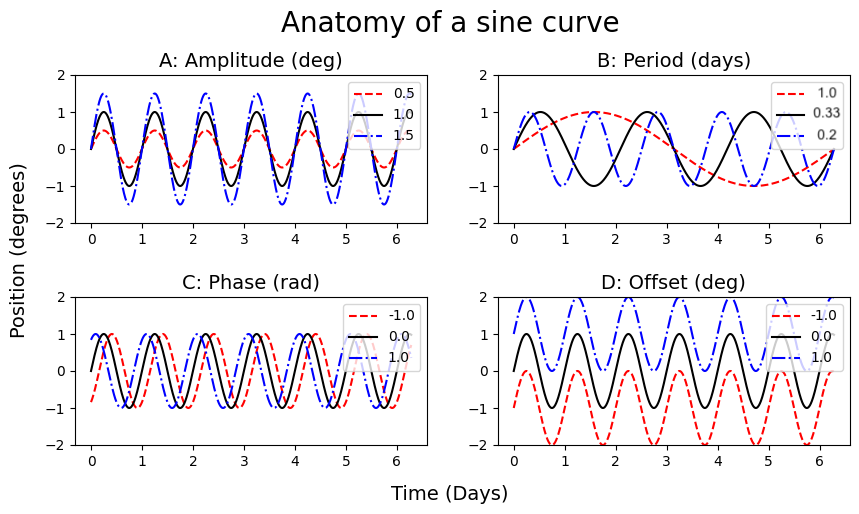

**Fit a sine curve to moon observations "by hand"**

Use the table below to input initial parameters for each of the four moon position data sets. Click the "Submit" button to enter values. Look at the plots of the data and consider how you might make a good first guess. (What is the min and max of the data? What would you estimate that the period of the sine wave is? etc.)

In [ ]:
#@title Input initial parameter values here

# create data table to enter initial parameter guesses (p_0) into 

# Extract the dX_pos, dY_pos and DateTime columns for each moon
M1_dx = df['Moon1 (dRA)'].values.reshape(-1, 1)
M1_dy = df['Moon1 (dDec)'].values.reshape(-1, 1)
M2_dx = df['Moon2 (dRA)'].values.reshape(-1, 1)
M2_dy = df['Moon2 (dDec)'].values.reshape(-1, 1)
date = df['Decimal Day (UT)'].values.reshape(-1, 1)
date_pred = np.arange(min_date, max_date, 0.025)

# format data
M1_dx_vec = M1_dx.flatten()
M1_dy_vec = M1_dy.flatten()
M2_dx_vec = M2_dx.flatten()
M2_dy_vec = M2_dy.flatten()

# Create the parameter names and model names
params = ['A (º)', 'B (days)', 'C (rad)', 'D (º)']
models = ['Moon1_dRA', 'Moon1_dDec', 'Moon2_dRA', 'Moon2_dDec']

# Create a dictionary to store the parameter values for each model
model_params = {}

# Create the widgets for the table cells
cell_widgets = [[widgets.FloatText(description = params[i], value = 0) for i in range(len(params))] for j in range(len(models))]

# Create the widgets for the row headers
row_headers = [widgets.HTML(value = model) for model in models]

# Create the layout for the table
table_layout = widgets.GridBox(
    children = [widgets.VBox([row_headers[i]] + cell_widgets[i]) for i in range(len(models))],
    layout = widgets.Layout(grid_template_columns = 'repeat(4, 310px)'))

# Create a button to submit the parameter values
button = widgets.Button(description = 'Submit/ Resubmit')

# create output widget
output1 = widgets.Output()

# Define the function to be called when the button is clicked
def on_button_clicked(button):
    for i, model in enumerate(models):
        model_params[model] = [cell_widgets[i][j].value for j in range(len(params))]
    print('Parameter values submitted successfully!')

    with output1: 

      clear_output()

      # --------
      # ALSO PLOT ON BUTTON CLICK
      # --------

      # extract p_0 values from data table 
      m1x_A_p0 = cell_widgets[0][0].value
      if cell_widgets[0][1].value == 0: # to avoid dividing by zero
        m1x_B_p0 = 0
      else:
        m1x_B_p0 = 2*np.pi/(cell_widgets[0][1].value)
      m1x_C_p0 = cell_widgets[0][2].value
      m1x_D_p0 = cell_widgets[0][3].value

      m1y_A_p0 = cell_widgets[1][0].value
      if cell_widgets[1][1].value == 0: # to avoid dividing by zero
        m1y_B_p0 = 0
      else:
        m1y_B_p0 = 2*np.pi/(cell_widgets[1][1].value)
      m1y_C_p0 = cell_widgets[1][2].value
      m1y_D_p0 = cell_widgets[1][3].value

      m2x_A_p0 = cell_widgets[2][0].value
      if cell_widgets[2][1].value == 0: # to avoid dividing by zero
        m2x_B_p0 = 0
      else:
        m2x_B_p0 = 2*np.pi/(cell_widgets[2][1].value)
      m2x_C_p0 = cell_widgets[2][2].value
      m2x_D_p0 = cell_widgets[2][3].value

      m2y_A_p0 = cell_widgets[3][0].value
      if cell_widgets[3][1].value == 0: # to avoid dividing by zero
        m2y_B_p0 = 0
      else:
        m2y_B_p0 = 2*np.pi/(cell_widgets[3][1].value)
      m2y_C_p0 = cell_widgets[3][2].value
      m2y_D_p0 = cell_widgets[3][3].value

      # create p_0 sin curves to plot
      m1dx_sin_p0 = m1x_A_p0 * np.sin(m1x_B_p0 * date_pred + m1x_C_p0) + m1x_D_p0
      m1dy_sin_p0 = m1y_A_p0 * np.sin(m1y_B_p0 * date_pred + m1y_C_p0) + m1y_D_p0
      m2dx_sin_p0 = m2x_A_p0 * np.sin(m2x_B_p0 * date_pred + m2x_C_p0) + m2x_D_p0
      m2dy_sin_p0 = m2y_A_p0 * np.sin(m2y_B_p0 * date_pred + m2y_C_p0) + m2y_D_p0

      # create p_0 sin predictions for residuals & r2
      m1dx_sin_date_p0 = m1x_A_p0 * np.sin(m1x_B_p0 * date + m1x_C_p0) + m1x_D_p0
      m1dy_sin_date_p0 = m1y_A_p0 * np.sin(m1y_B_p0 * date + m1y_C_p0) + m1y_D_p0
      m2dx_sin_date_p0 = m2x_A_p0 * np.sin(m2x_B_p0 * date + m2x_C_p0) + m2x_D_p0
      m2dy_sin_date_p0 = m2y_A_p0 * np.sin(m2y_B_p0 * date + m2y_C_p0) + m2y_D_p0

      # calculate r2 for fits
      r2 = r2_score(M1_dx, m1dx_sin_date_p0)
      m1x_sin_p0_r2 = "R$^2$ = %.2f" % round(r2,2) # r2

      r2 = r2_score(M1_dy, m1dx_sin_date_p0)
      m1y_sin_p0_r2 = "R$^2$ = %.2f" % round(r2,2) # r2

      r2 = r2_score(M2_dx, m2dx_sin_date_p0)
      m2x_sin_p0_r2 = "R$^2$ = %.2f" % round(r2,2) # r2

      r2 = r2_score(M2_dy, m2dx_sin_date_p0)
      m2y_sin_p0_r2 = "R$^2$ = %.2f" % round(r2,2) # r2

      # calculate residuals
      m1dx_sin_p0_resid = M1_dx - m1dx_sin_date_p0
      m1dy_sin_p0_resid = M1_dy - m1dy_sin_date_p0
      m2dx_sin_p0_resid = M2_dx - m2dx_sin_date_p0
      m2dy_sin_p0_resid = M2_dy - m2dy_sin_date_p0

      # calculate min and max residuals to define y-axis of resid plots
      min_m1xresid_sin_p0 = np.min(m1dx_sin_p0_resid)
      min_m1yresid_sin_p0 = np.min(m1dy_sin_p0_resid)
      min_m2xresid_sin_p0 = np.min(m2dx_sin_p0_resid)
      min_m2yresid_sin_p0 = np.min(m2dy_sin_p0_resid)

      min_resid_sin_p0 = min(min_m1xresid_sin_p0, min_m1yresid_sin_p0, min_m2xresid_sin_p0, min_m2yresid_sin_p0) * 1.4

      max_m1xresid_sin_p0 = np.max(m1dx_sin_p0_resid)
      max_m1yresid_sin_p0 = np.max(m1dy_sin_p0_resid)
      max_m2xresid_sin_p0 = np.max(m2dx_sin_p0_resid)
      max_m2yresid_sin_p0 = np.max(m2dy_sin_p0_resid)

      max_resid_sin_p0 = max(max_m1xresid_sin_p0, max_m1yresid_sin_p0, max_m2xresid_sin_p0, max_m2yresid_sin_p0) * 1.4


      # ========
      # Figure of p_0 model fits and residuals
      # ========

      # create figure outside the function so we update the same one
      fig, ((moon1, moon2), (moon1resid, moon2resid)) = plt.subplots(nrows=2, ncols=2, figsize=(11, 7), gridspec_kw={'height_ratios': [2, 1]})

      # Plot dX_pos vs DateTime and dY_pos vs DateTime for Moon 1
      # plot p_0 sin fits
      moon1.scatter(date, M1_dx, color = 'red', label = 'RA')
      moon1.plot(date_pred, m1dx_sin_p0, color = 'red', linewidth = 2, label = 'RA initial model')
      moon1.scatter(date, M1_dy, color = 'blue', marker='s', label = 'Dec')
      moon1.plot(date_pred, m1dy_sin_p0, color = 'blue', linestyle='--', linewidth = 2, label = 'Dec initital model')
      moon1.annotate(m1x_sin_p0_r2, xy=(0.03, 0.92), xycoords='axes fraction', color='red', fontsize=12, weight='bold',
                    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round'))
      moon1.annotate(m1y_sin_p0_r2, xy=(0.65, 0.92), xycoords='axes fraction', color='blue', fontsize=12, weight='bold',
                    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round'))
      moon1.set_title('Moon 1', fontsize = 16, fontweight = 'bold')
      moon1.set_ylabel('Δ Position (degrees)', fontsize = 14)
      moon1.set_ylim([min_dpos, max_dpos])
      moon1.set_xlim([min_date, max_date])

      # Plot dX_pos vs DateTime and dY_pos vs DateTime for Moon 2
      moon2.scatter(date, M2_dx, color = 'red', label = 'RA')
      moon2.plot(date_pred, m2dx_sin_p0, color = 'red', linewidth = 2, label = 'RA inittial model')
      moon2.scatter(date, M2_dy, color = 'blue', marker='s', label = 'Dec')
      moon2.plot(date_pred, m2dy_sin_p0, color = 'blue', linestyle='--', linewidth = 2, label = 'Dec inital model')
      moon2.annotate(m2x_sin_p0_r2, xy=(0.03, 0.92), xycoords='axes fraction', color='red', fontsize=12, weight='bold',
                    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round'))
      moon2.annotate(m2y_sin_p0_r2, xy=(0.65, 0.92), xycoords='axes fraction', color='blue', fontsize=12, weight='bold',
                    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round'))
      moon2.set_title('Moon 2', fontsize = 16, fontweight = 'bold')
      moon2.set_ylim([min_dpos, max_dpos])
      moon2.set_xlim([min_date, max_date])

      # moon 2 figure legend
      moon2.legend(loc = 'upper right', bbox_to_anchor = (1.6, 1), fontsize = 12)

      # plot residuals for moon 1
      moon1resid.stem(date, m1dx_sin_p0_resid, linefmt='r-', markerfmt='ro', basefmt='k-')  
      moon1resid.stem(date, m1dy_sin_p0_resid, linefmt='b-', markerfmt='bs', basefmt='k-')  
      moon1resid.set_ylabel('Residuals', fontsize = 14)
      moon1resid.set_ylim([-0.02, 0.02])
      moon1resid.set_xlim([min_date, max_date])

      # plot residuals for moon 2
      moon2resid.stem(date, m2dx_sin_p0_resid, linefmt='r-', markerfmt='ro', basefmt='k-', label = 'RA inital model')  
      moon2resid.stem(date, m2dy_sin_p0_resid, linefmt='b-', markerfmt='bs', basefmt='k-', label = "Dec initial model")  
      moon2resid.legend(loc = 'upper right', bbox_to_anchor = (1.6, 1), fontsize = 12)
      moon2resid.set_ylim([-0.02, 0.02])
      moon2resid.set_xlim([min_date, max_date])

      # Add a main x-axis label
      fig.text(0.5, 0, 'Day of Year', ha = 'center', fontsize = 14)

      # Add a main title
      fig.suptitle('Sine fits via iterative guesses', y = 1.05, fontsize = 20, fontweight = 'bold')
      fig.text(0.5, 1.00, "dX = A * sin(Bx + C) + D", ha = 'center', fontsize = 16, va = 'top')
      fig.text(0.5, 0.96, "A = Amplitude    B = Freq   C = Phase   D = Offset", ha = 'center', fontsize = 16, va = 'top')

      # Adjust the spacing between subplots
      fig.subplots_adjust(wspace = 0.2)

      # display the plot
      plt.show()

# Attach the function to the button's click event
button.on_click(on_button_clicked)

# Create title widget
title_widget = widgets.HTML(value='<h3>Input initial parameter values here </h3>')

# Display the title, table, and the button
display(title_widget)
display(widgets.VBox([table_layout, button]))
display(output1)


**Store your parameters here**

Type your parameter estimates here when you are satisfied with them. This way they won't be deleted if you come back to the file and press "Run All".

*double click me to edit this text and store your numbers!*

Moon1_ΔRA | A = __ , B = __ , C = __ , D = __

Moon1_ΔDec | A = __ , B = __ , C = __ , D = __

Moon2_ΔRA | A = __ , B = __ , C = __ , D = __

Moon2_ΔDec | A = __ , B = __ , C = __ , D = __

When you are satisfied with how well your sine curves match the data (they don't have to be perfect!), run the next code block. This block uses the scipy package to fit a sine curve to each dataset. The function to generate the best-fit parameters will use your initial parameters as a starting point. If one of your initial models is not a good fit, the function might not converge parameter solutions and you will see an error message. If this happens, return to the code block above and refine your  parameters guesses.

In [ ]:
#@title Fit a sin curve using the scipy package

# =========
# SIN FITS
# =========

# extract p_0 values from data table 
m1x_A_p0 = cell_widgets[0][0].value
if cell_widgets[0][1].value == 0: # to avoid dividing by zero
  m1x_B_p0 = 0
else:
  m1x_B_p0 = 2*np.pi/(cell_widgets[0][1].value)
m1x_C_p0 = cell_widgets[0][2].value
m1x_D_p0 = cell_widgets[0][3].value

m1y_A_p0 = cell_widgets[1][0].value
if cell_widgets[1][1].value == 0: # to avoid dividing by zero
  m1y_B_p0 = 0
else:
  m1y_B_p0 = 2*np.pi/(cell_widgets[1][1].value)
m1y_C_p0 = cell_widgets[1][2].value
m1y_D_p0 = cell_widgets[1][3].value

m2x_A_p0 = cell_widgets[2][0].value
if cell_widgets[2][1].value == 0: # to avoid dividing by zero
  m2x_B_p0 = 0
else:
  m2x_B_p0 = 2*np.pi/(cell_widgets[2][1].value)
m2x_C_p0 = cell_widgets[2][2].value
m2x_D_p0 = cell_widgets[2][3].value

m2y_A_p0 = cell_widgets[3][0].value
if cell_widgets[3][1].value == 0: # to avoid dividing by zero
  m2y_B_p0 = 0
else:
  m2y_B_p0 = 2*np.pi/(cell_widgets[3][1].value)
m2y_C_p0 = cell_widgets[3][2].value
m2y_D_p0 = cell_widgets[3][3].value

# also recreate the curves outside of the above function
m1dx_sin_p0 = m1x_A_p0 * np.sin(m1x_B_p0 * date_pred + m1x_C_p0) + m1x_D_p0
m1dy_sin_p0 = m1y_A_p0 * np.sin(m1y_B_p0 * date_pred + m1y_C_p0) + m1y_D_p0
m2dx_sin_p0 = m2x_A_p0 * np.sin(m2x_B_p0 * date_pred + m2x_C_p0) + m2x_D_p0
m2dy_sin_p0 = m2y_A_p0 * np.sin(m2y_B_p0 * date_pred + m2y_C_p0) + m2y_D_p0


# fit sin curve using scipy
def sine_func(x, A, B, C, D):     # define the function to fit
    return A * np.sin(B * x + C) + D

number_iterations = 10000

# define p_0 vectors from "hand fits" above
m1x_p0 = [m1x_A_p0, m1x_B_p0, m1x_C_p0, m1x_D_p0]
m1y_p0 = [m1y_A_p0, m1y_B_p0, m1y_C_p0, m1y_D_p0]
m2x_p0 = [m2x_A_p0, m2x_B_p0, m2x_C_p0, m2x_D_p0]
m2y_p0 = [m2y_A_p0, m2y_B_p0, m2y_C_p0, m2y_D_p0]

# moon 1 dx
#m1x_p0 = [0.01, 0.7, 0, 0]
m1x_popt, m1x_pcov = curve_fit(sine_func, date_vec, M1_dx_vec, p0 = m1x_p0, maxfev = number_iterations)
m1x_sin_pred = sine_func(date, *m1x_popt) # predicted values for obs
m1x_sin_pred_plot = sine_func(date_pred, *m1x_popt) # predicted values for plotting
r2 = r2_score(M1_dx_vec, m1x_sin_pred)
m1x_sin_r2 = "R$^2$ = %.2f" % round(r2,2) # r2
m1x_resid_sin = M1_dx - m1x_sin_pred #residuals
m1x_A = m1x_popt[0] # store parameter estimates
m1x_B = 2*np.pi/m1x_popt[1]
m1x_C = m1x_popt[2]
m1x_D = m1x_popt[3]

# moon 1 dy
#m1y_p0 = [0.01, 0.6, 0, 0]
m1y_popt, m1y_pcov = curve_fit(sine_func, date_vec, M1_dy_vec, p0 = m1y_p0, maxfev = number_iterations)
m1y_sin_pred = sine_func(date, *m1y_popt) # predicted values for obs
m1y_sin_pred_plot = sine_func(date_pred, *m1y_popt) # predicted values for plotting
r2 = r2_score(M1_dy_vec, m1y_sin_pred)
m1y_sin_r2 = "R$^2$ = %.2f" % round(r2,2) # r2
m1y_resid_sin = M1_dy - m1y_sin_pred #residuals
m1y_A = m1y_popt[0] # store parameter estimates
m1y_B = 2*np.pi/m1y_popt[1]
m1y_C = m1y_popt[2]
m1y_D = m1y_popt[3]

# moon 2 dx
#m2x_p0 = [0.01, 0.7, 0, 0]
m2x_popt, m2x_pcov = curve_fit(sine_func, date_vec, M2_dx_vec, p0 = m2x_p0, maxfev = number_iterations)
m2x_sin_pred = sine_func(date, *m2x_popt) # predicted values for obs
m2x_sin_pred_plot = sine_func(date_pred, *m2x_popt) # predicted values for plotting
r2 = r2_score(M2_dx_vec, m2x_sin_pred)
m2x_sin_r2 = "R$^2$ = %.2f" % round(r2,2) # r2
m2x_resid_sin = M2_dx - m2x_sin_pred #residuals
m2x_A = m2x_popt[0] # store parameter estimates
m2x_B = 2*np.pi/m2x_popt[1]
m2x_C = m2x_popt[2]
m2x_D = m2x_popt[3]

# moon 2 dy
#m2y_p0 = [0.01, 0.7, 0, 0]
m2y_popt, m2y_pcov = curve_fit(sine_func, date_vec, M2_dy_vec, p0 = m2y_p0, maxfev = number_iterations)
m2y_sin_pred = sine_func(date, *m2y_popt) # predicted values for obs
m2y_sin_pred_plot = sine_func(date_pred, *m2y_popt) # predicted values for plotting
r2 = r2_score(M2_dy_vec, m2y_sin_pred)
m2y_sin_r2 = "R$^2$ = %.2f" % round(r2,2) # r2
m2y_resid_sin = M2_dy - m2y_sin_pred #residuals
m2y_A = m2y_popt[0] # store parameter estimates
m2y_B = 2*np.pi/m2y_popt[1]
m2y_C = m2y_popt[2]
m2y_D = m2y_popt[3]


# ========
# Figure of p_0, p_F model fits and residuals
# ========
fig, ((moon1, moon2), (moon1resid, moon2resid)) = plt.subplots(nrows=2, ncols=2, figsize=(11, 7), gridspec_kw={'height_ratios': [2, 1]})

# Plot dX_pos vs DateTime and dY_pos vs DateTime for Moon 1
# plot p_0 sin fits
moon1.scatter(date, M1_dx, color = 'red', label = 'RA')
moon1.plot(date_pred, m1dx_sin_p0, color = 'gray', linewidth = 2, label = 'RA initial model')
moon1.plot(date_pred, m1x_sin_pred_plot, color = 'red', linewidth = 2, label = 'RA final model')
moon1.scatter(date, M1_dy, color = 'blue', marker='s', label = 'Dec')
moon1.plot(date_pred, m1dy_sin_p0, color = 'gray', linestyle = '--', linewidth = 2, label = 'Dec initial model')
moon1.plot(date_pred, m1y_sin_pred_plot, color = 'blue', linestyle = '--', linewidth = 2, label = 'Dec final model')
moon1.annotate(m1x_sin_r2, xy=(0.03, 0.92), xycoords='axes fraction', color='red', fontsize=12, weight='bold',
               bbox=dict(facecolor='white', edgecolor='none', boxstyle='round'))
moon1.annotate(m1y_sin_r2, xy=(0.65, 0.92), xycoords='axes fraction', color='blue', fontsize=12, weight='bold',
               bbox=dict(facecolor='white', edgecolor='none', boxstyle='round'))
moon1.set_title('Moon 1', fontsize = 16, fontweight = 'bold')
moon1.set_ylabel('Δ Position (degrees)', fontsize = 14)
moon1.set_ylim([min_dpos, max_dpos])
moon1.set_xlim([min_date, max_date])

# Plot dX_pos vs DateTime and dY_pos vs DateTime for Moon 2
moon2.scatter(date, M2_dx, color = 'red', label = 'RA')
moon2.plot(date_pred, m2dx_sin_p0, color = 'gray', linewidth = 2, label = 'RA initial model')
moon2.plot(date_pred, m2x_sin_pred_plot, color = 'red', linewidth = 2, label = 'RA final model')
moon2.scatter(date, M2_dy, color = 'blue', marker='s', label = 'Dec')
moon2.plot(date_pred, m2dy_sin_p0, color = 'gray', linestyle = '--', linewidth = 2, label = 'Dec initial model')
moon2.plot(date_pred, m2y_sin_pred_plot, color = 'blue', linestyle='--', linewidth = 2, label = 'Dec final model')
moon2.annotate(m2x_sin_r2, xy=(0.03, 0.92), xycoords='axes fraction', color='red', fontsize=12, weight='bold',
               bbox=dict(facecolor='white', edgecolor='none', boxstyle='round'))
moon2.annotate(m2y_sin_r2, xy=(0.65, 0.92), xycoords='axes fraction', color='blue', fontsize=12, weight='bold',
               bbox=dict(facecolor='white', edgecolor='none', boxstyle='round'))
moon2.set_title('Moon 2', fontsize = 16, fontweight = 'bold')
moon2.set_ylim([min_dpos, max_dpos])
moon2.set_xlim([min_date, max_date])

# moon 2 figure legend
moon2.legend(loc = 'upper right', bbox_to_anchor = (1.6, 1), fontsize = 12)

# plot residuals for moon 1
moon1resid.stem(date, m1x_resid_sin, linefmt='r-', markerfmt='ro', basefmt='k-')  
moon1resid.stem(date, m1y_resid_sin, linefmt='b-', markerfmt='bs', basefmt='k-')  
moon1resid.set_ylabel('Residuals', fontsize = 14)
moon1resid.set_ylim([-0.02, 0.02])
moon1resid.set_xlim([min_date, max_date])

# plot residuals for moon 2
moon2resid.stem(date, m2x_resid_sin, linefmt='r-', markerfmt='ro', basefmt='k-', label = 'RA final model')  
moon2resid.stem(date, m2y_resid_sin, linefmt='b-', markerfmt='bs', basefmt='k-', label = "Dec final model")  
moon2resid.legend(loc = 'upper right', bbox_to_anchor = (1.6, 1), fontsize = 12)
moon2resid.set_ylim([-0.02, 0.02])
moon2resid.set_xlim([min_date, max_date])

# Add a main x-axis label
fig.text(0.5, 0, 'Day of Year', ha = 'center', fontsize = 14)

# Add a main title
fig.suptitle('Sin fit via scipy package', y = 1.04, fontsize = 20, fontweight = 'bold')
fig.text(0.5, 0.99, "Compare your initial model to the final model", ha = 'center', fontsize = 16, va = 'top')

# Adjust the spacing between subplots
fig.subplots_adjust(wspace = 0.2)

# display the plot
plt.show()


# ========
# Data table of parameters for final models
# ========
# Combining parameters for all four model into a single array

# convert table versions back to period
m1x_popt[1] = 2*np.pi/m1x_popt[1]
m1y_popt[1] = 2*np.pi/m1y_popt[1]
m2x_popt[1] = 2*np.pi/m2x_popt[1]
m2y_popt[1] = 2*np.pi/m2y_popt[1]

combined_params = np.stack([m1x_popt, m1y_popt, m2x_popt, m2y_popt])
df_params = pd.DataFrame(combined_params, index=['Moon 1 dRA', 'Moon 1 dDec', 'Moon 2 dRA', 'Moon 2 dDec'], columns=['A', 'B', 'C', 'D'])
df_params = df_params.round(3)
df_params.style.set_caption('Parameter Estimates')
display(df_params)


## RESPONSE 4

**Questions:**

1. Which model fits the data better -- your initial model or the Scipy final model? What evidence did you consider to make this determination?
2. Record the optimized A, B, C,and D parameters that you got from each model fit (also be sure to save your A, B, C, and D guesses from above). You will need A and B values for the $\Delta$ RA and $\Delta$ Dec fits for Moon 1 and Moon 2 in the next step.

---

**Answers:**

*double click me to edit this text and respond to the questions!*

In [ ]:
from numpy.lib.function_base import add_newdoc
#@title Calculate the mass of Uranus - **Edit Code**


# +++++++++++++
# README
# +++++++++++++

# you are given that the distance to Uranus is 19.2 AU
# in this block, you will create variables and solve for the mass of Uranus


# -------------
# But what's a variable? 
# -------------
# A variable is a coding object that stores a value or a whole set of values
# A few examples of how to use variables are shown below
# RUN THIS CODE BLOCK to see the output of these commands:


myvariable = 2
# ^ this assigns the value 2 to a variable called "myvariable"

# if we print out the value of myvariable, we'll see that it is 2
print("myvariable = %.1f\n" % myvariable)

# if we change the value of myvariable, that value will overwrite the previous one
myvariable = 34
print("myvariable = %.1f\n" % myvariable)

# we can also create a new variable from an old variable
# Let's multiply myvariable by 2 and store that value in myvariable_2
# * is the multiplication operator
myvariable_2 = myvariable*2
print("myvariable*2 = %.1f\n" % myvariable_2)

# we can even use variables together
# / is the division operator
myvariable_3 = myvariable_2/myvariable
print("myvariable_2/myvariable = %.1f\n" % myvariable_3)

# this means we can use python just like a calculator!

# RULES ABOUT VARIABLE NAMES
# - keep them unique! if you try to store two values in one variable, it will only keep the newest
# - variables can't contain spaces, and can't start with a number
# - variables can't shouldn't usually contain special characters, except for underscore "_"
# - try not to name variables the same name as functions. For instance, the "print" function above
#   lets us print something to the output below this code block. But if we created a variable called
#   "print" the print function won't work anymore!


# -------------
# you also will need to use some functions to do your calculation! 
# -------------
# A function is a named operation that might do multiple mathematical things all at once!

# a classic example is the square root function. We can't use the square root character for this
# so instead we use "np.sqrt()" the value we want to square root goes inside the parentheses
# just like other math in python, you can take the squareroot of a variable, and you can also 
# leave unsimplified math inside the parentheses

myvariable_4 = np.sqrt(myvariable + 2)
print("The square root of myvariable + 2 is %.1f\n" % myvariable_4)



# -------------
# Also also, this is a comment (what you are reading right now)!
# -------------

# create a comment by starting a line with a hashtag (#)
# This won't be run by the code, but is REALLY USEFUL for leaving notes to yourself
# you can even do it right after a line of code:

G = 6.674*10**-11 # in units of m^3 kg^-1 s^-2
# ^ you can use this if you want ;)



# Now it's your turn!

# =============
# USING YOUR PARAMETERS FROM THE FITS ABOVE,
# FIND THE MASS OF URANUS
# =============

# other helpful functions or commands:
# - np.pi is the value of pi, this works just like a number (e.g. np.pi*2 = 6.28)
# - np.cos(x) takes the cos of x (where x is in radians)
# - np.deg2rad(x) converts x from degrees to radians
# - x**2 takes the square of x
# - x**3 takes the cube of x
# - x**n takes x to the nth power (replace n with a number or a variable)
# - np.sqrt(x) takes the square root of x

# you may also want to take the mean of two estimates, one from moon 1 and one from moon 2
# - np.mean([x1,x2]) takes the mean of all values in the square brackets, separated by a comma


# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# YOUR CODE HERE







m_uranus = 0 #replace this 0 with the variable of your final answer to print it out!

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

print("\nThe mass of Uranus is estimated to be %.2e kg" % m_uranus)

## RESPONSE 5

*Congrats! You just wrote some python code!*

**Questions:**

1.   Is the mass of Uranus that you calculated consistent with the known mass of Uranus? (Check online at http://theskylive.com/uranus-info)
2.   List and discuss any potential sources of error that may have impacted your results and your mass calculation.

---

**Answers:**

*double click me to edit this text and respond to the questions!*



# Part 4: Estimating the Mass from Multiple Distances

## Why use multiple distances?

In the calculation you just completed, you used a single estimate of the period and axis of rotation of Uranus' moons, and a single estimate of the distance (the average distance between Uranus and the Earth, 19.2 AU). But the Earth and Uranus are constantly in motion around the sun at different rates, so how can we know that the average distance was the actual distance when the observations were taken? The answer is: we can't know without a lot more math.

Let's say that we couldn't find the exact distance because we did not know the date of our observations, but we had some estimate of the distance (19.2 AU). **We could instead ask computer code to simulate a range of possible distances from this estimate, and then use those distances to calculate a range of possible masses.** Simulating a distribution of outputs from a distribution of inputs like this is called a **Monte Carlo** simulation, named after a famous casino in Monaco.

In this case, we could ask the computer to randomly generate positions of the Earth and Uranus around the sun, and then use trigonometry to find the distance. Assuming a circular orbit for both Uranus and the Earth, and that the Earth orbits much faster than Uranus, it would be fair to simplify this simulation by leaving Uranus *fixed* in space, and choosing positions for Earth by some angle around the sun: Θ. Then we use the law of cosines to find the distance from Uranus to Earth given that the Earth is 1 AU from the Sun, and Uranus is 19.2 AU from the Sun. 

The animation below shows a graphical example of this simulation. See the next code block for the resulting distribution of distances.

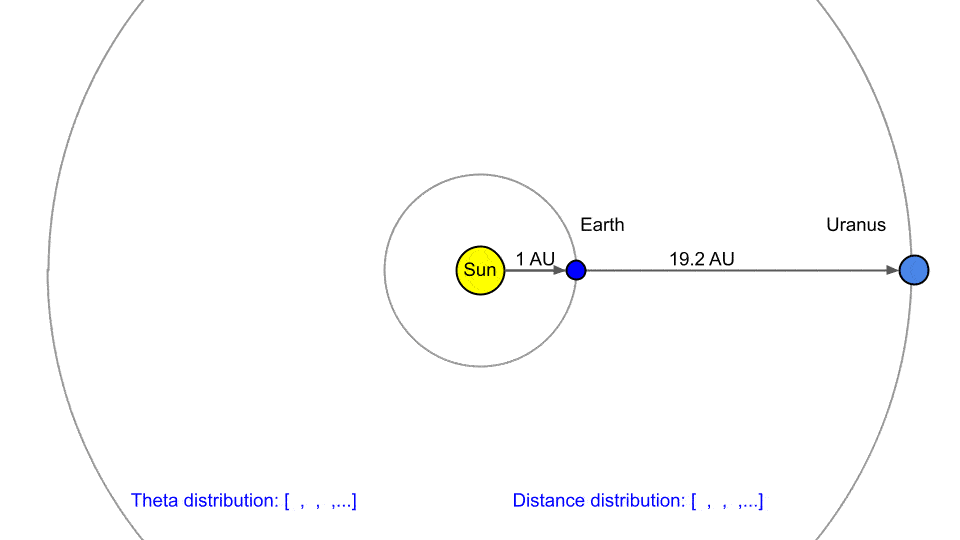

In [ ]:
#@title Simulate the distance from the Earth to Uranus

# ============
# GENERATE ANGLES
# ============

sampler01 = qmc.LatinHypercube(d = 1, seed = 42) # a random number algorithm
sample01 = sampler01.random(n=10000) # pulling 10000 numbers out at random

angle_sim = qmc.scale(sample01, [0],[2*np.pi])

# ============
# GENERATE DISTANCES
# ============

u_dist = 19.2 # distance from sun to Uranus, in AU
e_dist = 1 # distance from sun to Earth, in AU

randsim1 = []

for t in angle_sim:
  # law of cosines
  d = np.sqrt(u_dist**2 + e_dist**2 - 2*u_dist*e_dist*np.cos(t))

  randsim1 = np.append(randsim1, d)


randsim1 = np.resize(randsim1, (10000,))

mean_dist = np.mean(randsim1)

# ============
# PLOT
# ============

# Create histogram showing distance distribution
fig, ax = plt.subplots()
#ax.hist(randsim1, density = False, histtype='stepfilled', alpha = 0.5)
#ax.set_title("Simulation of Normal Distribution of Uranus Distance", fontsize = 16)
#ax.set_xlabel("Distance (AU)", fontsize = 14)
#ax.set_ylabel("Count", fontsize = 14)

# density function 
ax = sns.histplot(randsim1, kde = False, stat = "percent", binwidth = 0.25)
ax.set_title("Uranus Distance Simulation", fontsize = 16)
ax.set_xlabel("Distance (AU)", fontsize = 14)
ax.set_ylabel("Percent", fontsize = 14)
ax.axvline(mean_dist, color='red', linestyle='--', linewidth = 2, label='Mean')
ax.legend(labels=["Mean Value", "Histogram"])

plt.show()


##RESPONSE 6

This histogram shows the distribution of **10,000** simulated distance values. These values have an average of 19.2 AU still, but the distribution is *bimodal* meaning that it has two peaks of common values. This is because the distance from Uranus doesn't change much on the near side of the sun or the far side of sun.

**Questions:**

1.   What questions do you have about the concept of a Monte Carlo simulation?
2.   We had to make several assumptions to generate these distance values. Discuss how the simulation would change if we had more accurate elliptical orbits. 

---

**Answers:**

*double click me to edit this text and respond to the questions!*

In [ ]:
#@title Heatmap of Possible Masses vs. Possible Distances

widgeth = create_dropdown(["0%","1%","5%","10%","25%"],0,"Error")

# =============
# DISTANCES --> MASSES
# =============

# vectors to plot
sim_dist = randsim1*149597870691
sim_mass = []

# angles and values from before:
f_0_1 = 0.466 # for Moon 1
f_0_2 = 0.721 # for Moon 2

T_t_1 = 2*np.pi/f_0_1 # make it a period of days
T_t_2 = 2*np.pi/f_0_2

T_0_1 = (T_t_1)*24*3600 # to seconds
T_0_2 = (T_t_2)*24*3600

a_d_1 = np.deg2rad(0.01) # in degrees, converted to rad, M1, average of 0.009 and 0.011
a_d_2 = np.deg2rad(0.0075) # in degrees, converted to rad, M2, average of 0.007 and 0.008

G = 6.674*10**-11 # in m^3 kg^-1 s^-2

# generate masses
for d in sim_dist:
  # law of cosines
  a_m_1 = np.sqrt(d**2 + d**2 - 2*d**2*np.cos(a_d_1))
  a_m_2 = np.sqrt(d**2 + d**2 - 2*d**2*np.cos(a_d_2))

  # kepler's law
  m_uranus_1 = ((4*np.pi**2)*a_m_1**3)/(G*T_0_1**2)
  m_uranus_2 = ((4*np.pi**2)*a_m_2**3)/(G*T_0_2**2)

  m_uranus = np.mean([m_uranus_1, m_uranus_2])

  sim_mass = np.append(sim_mass, m_uranus)

# resize distances to one dimension!!!
sim_dist = np.resize(sim_dist, (10000,))

# **********
# generate error distribution
# **********

sampler02 = qmc.LatinHypercube(d = 1, seed = 54) # a random number algorithm
sample02 = sampler02.random(n=10000) # pulling 10000 numbers out at random

sim2 = norm(0.5,0.5/3) # define a normal distribution for the distance
randsim2 = sim2.ppf(sample02) # align the random sample with the normal distribution

sim_err = np.resize(randsim2, (10000,))

# ==========
# 2D HISTOGRAM PLOT
# ==========

def heatmap_plot(droph):

  if droph == "1%":
    sim_err_sc = sim_err*0.02 - 0.01
    sim_mass_e = []
    for p,e in zip(sim_mass,sim_err_sc):
      new_pt = p + p*e
      sim_mass_e = np.append(sim_mass_e, new_pt)
  elif droph == "5%":
    sim_err_sc = sim_err*0.1 - 0.05
    sim_mass_e = []
    for p,e in zip(sim_mass,sim_err_sc):
      new_pt = p + p*e
      sim_mass_e = np.append(sim_mass_e, new_pt)
  elif droph == "10%":
    sim_err_sc = sim_err*0.2 - 0.1
    sim_mass_e = []
    for p,e in zip(sim_mass,sim_err_sc):
      new_pt = p + p*e
      sim_mass_e = np.append(sim_mass_e, new_pt)
  elif droph == "25%":
    sim_err_sc = sim_err*0.5 - 0.25
    sim_mass_e = []
    for p,e in zip(sim_mass,sim_err_sc):
      new_pt = p + p*e
      sim_mass_e = np.append(sim_mass_e, new_pt)
  else:
    sim_mass_e = sim_mass

  fig, (s1, s2, s3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
  s1.hist(sim_dist, density = False, histtype='stepfilled', alpha = 0.5)
  s2.hist(sim_mass_e, density = False, histtype='stepfilled', alpha = 0.5)
  s3.scatter(sim_dist,sim_mass_e, alpha = 0.1)
  s1.set_title("Distance Histogram", fontsize = 16)
  s2.set_title("Mass Histogram", fontsize = 16)
  s3.set_title("Distance vs. Mass", fontsize = 16)
  s1.set_xlabel("Distance (AU)", fontsize = 14)
  s2.set_xlabel("Mass (kg)", fontsize = 14)
  s3.set_xlabel("Distance (AU)", fontsize = 14)
  s1.set_ylabel("Count", fontsize = 14)
  s2.set_ylabel("Count", fontsize = 14)
  s3.set_ylabel("Mass (kg)", fontsize = 14)
  fig.subplots_adjust(wspace = 0.4)
  fig.suptitle('Simulation Results', fontsize=20, y=1.05)
  plt.show()

  counts, yedges, xedges = np.histogram2d(sim_mass_e, sim_dist, bins=30)

  fig, ax = plt.subplots()
  pos = ax.pcolormesh(xedges, yedges, counts, cmap='hot_r')
  ax.set_xlim(0.98*sim_dist.min(), 1.02*sim_dist.max())
  ax.set_ylim(sim_mass_e.min(), sim_mass_e.max())
  ax.set_xlabel('Distance (m)', fontsize = 14)
  ax.set_ylabel('Mass (kg)', fontsize = 14)
  ax.set_title('Heat Map of results', fontsize = 16)
  ax.grid()
  cb = fig.colorbar(pos, ax=ax)
  cb.set_label('Count')

  plt.show()


widgets.interact(heatmap_plot, droph = widgeth)




##A Different Distribution

Below, the same simulation is run again, but for a different distribution of distances. That is, the **distance distribution takes a different shape**. The distribution is now "normal" with a mean of 19.2 AU and a standard deviation of 0.5 AU. Instead of being bimodal, this distribution is *unimodal*, which gives the heatmap a different shape. Take a look!

In [ ]:
#@title Heatmap of Masses vs. Distances for Normal Distribution

widgeth2 = create_dropdown(["0%","1%","5%","10%","25%"],0,"Error")

# =============
# SIM NORMAL DISTANCES
# ============= 

m_dist = 19.2
s_dist = 0.5

sampler03 = qmc.LatinHypercube(d = 1, seed = 44) # a random number algorithm
sample03 = sampler03.random(n=10000) # pulling 10000 numbers out at random

sim3 = norm(m_dist,s_dist) # define a normal distribution for the distance
randsim3 = sim3.ppf(sample03) # align the random sample with the normal distribution

# =============
# DISTANCES --> MASSES
# =============

# vectors to plot
sim_dist2 = randsim3*149597870691
sim_mass2 = []

# angles and values from before:
f_0_1 = 0.466 # for Moon 1
f_0_2 = 0.721 # for Moon 2

T_t_1 = 2*np.pi/f_0_1 # make it a period of days
T_t_2 = 2*np.pi/f_0_2

T_0_1 = (T_t_1)*24*3600 # to seconds
T_0_2 = (T_t_2)*24*3600

a_d_1 = np.deg2rad(0.01) # in degrees, converted to rad, M1, average of 0.009 and 0.011
a_d_2 = np.deg2rad(0.0075) # in degrees, converted to rad, M2, average of 0.007 and 0.008

G = 6.674*10**-11 # in m^3 kg^-1 s^-2

# generate masses
for d in sim_dist2:
  # law of cosines
  a_m_1 = np.sqrt(d**2 + d**2 - 2*d**2*np.cos(a_d_1))
  a_m_2 = np.sqrt(d**2 + d**2 - 2*d**2*np.cos(a_d_2))

  # kepler's law
  m_uranus_1 = ((4*np.pi**2)*a_m_1**3)/(G*T_0_1**2)
  m_uranus_2 = ((4*np.pi**2)*a_m_2**3)/(G*T_0_2**2)

  m_uranus = np.mean([m_uranus_1, m_uranus_2])

  sim_mass2 = np.append(sim_mass2, m_uranus)

# resize distances to one dimension!!!
sim_dist2 = np.resize(sim_dist2, (10000,))

# don't need a new error distribution because we can use the same one as before


def heatmap_plot2(droph):

  if droph == "1%":
    sim_err_sc = sim_err*0.02 - 0.01
    sim_mass_e2 = []
    for p,e in zip(sim_mass2,sim_err_sc):
      new_pt = p + p*e
      sim_mass_e2 = np.append(sim_mass_e2, new_pt)
  elif droph == "5%":
    sim_err_sc = sim_err*0.1 - 0.05
    sim_mass_e2 = []
    for p,e in zip(sim_mass2,sim_err_sc):
      new_pt = p + p*e
      sim_mass_e2 = np.append(sim_mass_e2, new_pt)
  elif droph == "10%":
    sim_err_sc = sim_err*0.2 - 0.1
    sim_mass_e2 = []
    for p,e in zip(sim_mass2,sim_err_sc):
      new_pt = p + p*e
      sim_mass_e2 = np.append(sim_mass_e2, new_pt)
  elif droph == "25%":
    sim_err_sc = sim_err*0.5 - 0.25
    sim_mass_e2 = []
    for p,e in zip(sim_mass2,sim_err_sc):
      new_pt = p + p*e
      sim_mass_e2 = np.append(sim_mass_e2, new_pt)
  else:
    sim_mass_e2 = sim_mass2

  fig, (s1, s2, s3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
  s1.hist(sim_dist2, density = False, histtype='stepfilled', alpha = 0.5)
  s2.hist(sim_mass_e2, density = False, histtype='stepfilled', alpha = 0.5)
  s3.scatter(sim_dist2,sim_mass_e2, alpha = 0.1)
  s1.set_title("Distance Histogram", fontsize = 16)
  s2.set_title("Mass Histogram", fontsize = 16)
  s3.set_title("Distance vs. Mass", fontsize = 16)
  s1.set_xlabel("Distance (AU)", fontsize = 14)
  s2.set_xlabel("Mass (kg)", fontsize = 14)
  s3.set_xlabel("Distance (AU)", fontsize = 14)
  s1.set_ylabel("Count", fontsize = 14)
  s2.set_ylabel("Count", fontsize = 14)
  s3.set_ylabel("Mass (kg)", fontsize = 14)
  fig.subplots_adjust(wspace = 0.4)
  fig.suptitle('Simulation Results', fontsize=20, y=1.05)
  plt.show()

  counts, yedges, xedges = np.histogram2d(sim_mass_e2, sim_dist2, bins=30)

  fig, ax = plt.subplots()
  pos = ax.pcolormesh(xedges, yedges, counts, cmap='hot_r')
  ax.set_xlim(0.98*sim_dist2.min(), 1.02*sim_dist2.max())
  ax.set_ylim(sim_mass_e2.min(), sim_mass_e2.max())
  ax.set_xlabel('Distance (m)', fontsize = 14)
  ax.set_ylabel('Mass (kg)', fontsize = 14)
  ax.set_title('Heat Map of results', fontsize = 16)
  ax.grid()
  cb = fig.colorbar(pos, ax=ax)
  cb.set_label('Count')

  plt.show()


widgets.interact(heatmap_plot2, droph = widgeth2)

**RESPONSE 7**

The plot that we just produced is a 2D Histogram, so now the count on each square is represented by a color. For instance, with 0% error selected, there are around 700 items in the darkest bin near the point (2.87, 5.5). Be sure to keep an eye on the scale as you change the error.

With 0% error, we have a straight line because function is still one-to-one: one distance value generates one mass value. But calculations aren't always this cut and dry. Use the dropdown to introduce error into our calculations, effectively carrying measurement error along with us on our other parameters in addition to the distance.

With some uncertainty introduced, this plot looks a lot like [this plot of the correlation of the mass and distance of the Supermassive Black Hole at the center of the Milky Way from 2008.](https://www.astroexplorer.org/details/10_1086_592738_fg11) *That means that the calculations you just did are part of the work that real astronomers do every day!*

![image.png](https://s3.amazonaws.com/aasie/images/0004-637X/689/2/1044/10_1086_592738_fg11_lr.gif)

(Figure from Ghez et al.)

**Questions:**

1.   How does the heatmap change when you introduce error? Describe what you see.
2.  What other applications of this process can you think of? We looked at a known object for this lab, but what about an unknown object? What might we want to learn from tracking its position in the sky, and why?

---

**Answers:**

*double click me to edit this text and respond to the questions!*